In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv("dataset/FloodPrediction.csv")

In [3]:
df = df.drop(columns=["Station_Names", "Sl"])

In [4]:
df["Flood?"] = df["Flood?"].fillna(0)

In [5]:
df.head()

,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,0.0
1,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,0.0
2,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,0.0
3,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,0.0
4,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,0.0


<Axes: >

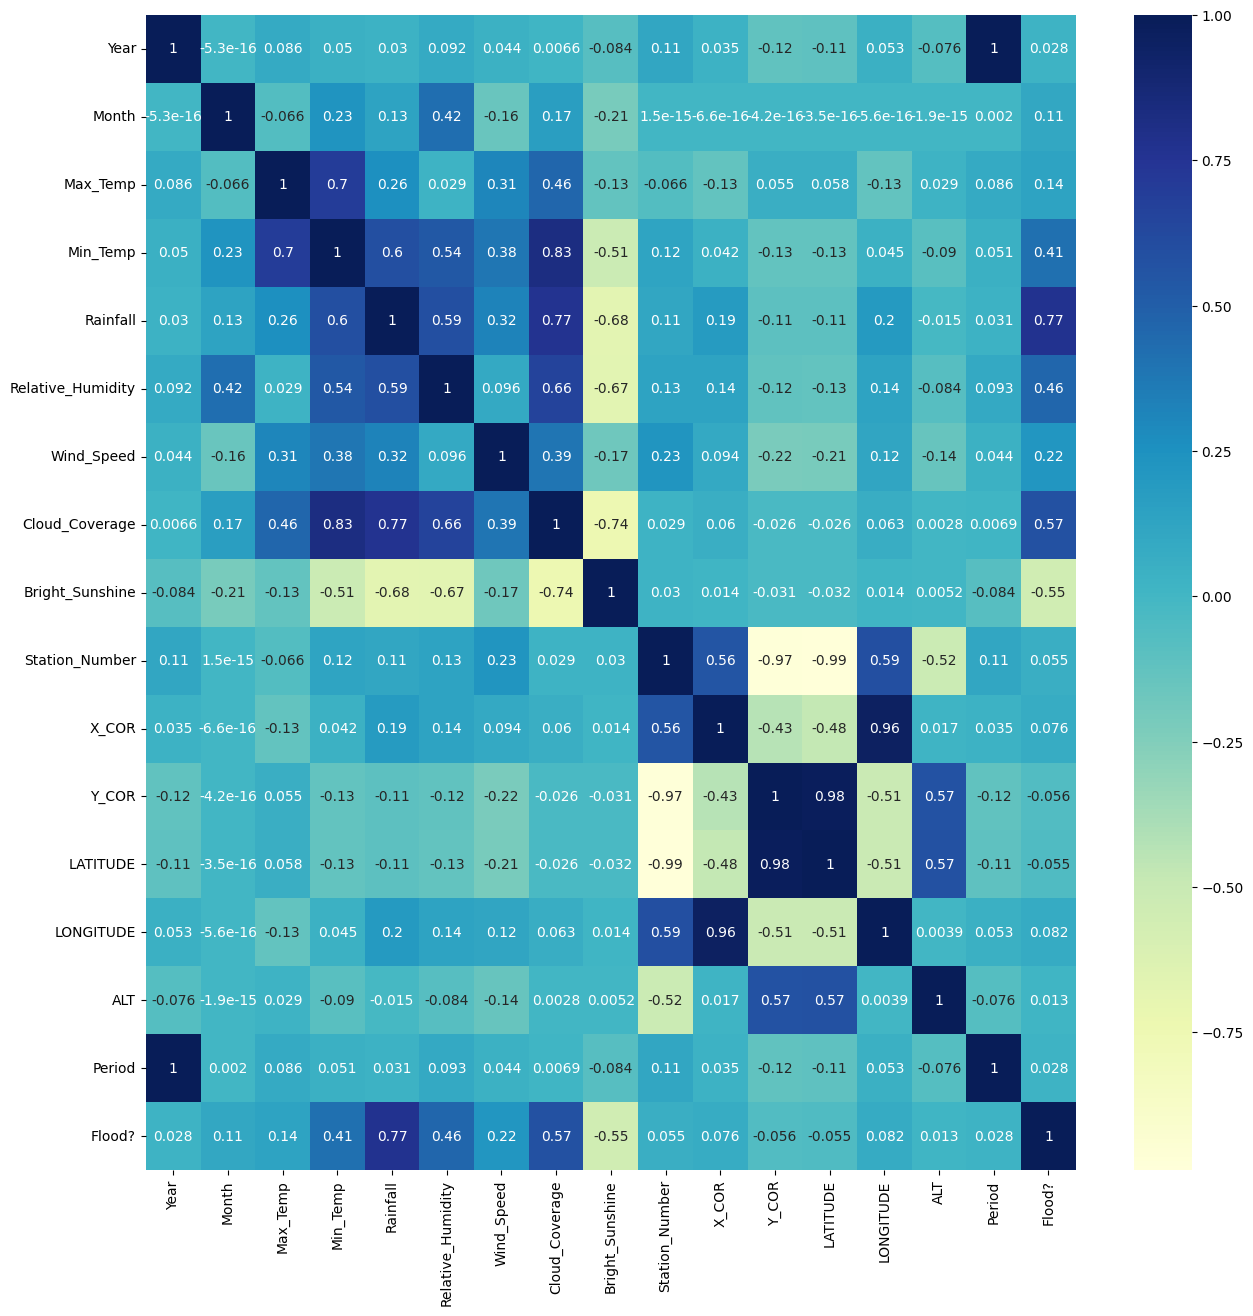

In [6]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

In [7]:
df = df.drop(columns=["Period","ALT","LONGITUDE", "LATITUDE", "X_COR", "Y_COR", "Station_Number", "Year", "Month"])

<Axes: >

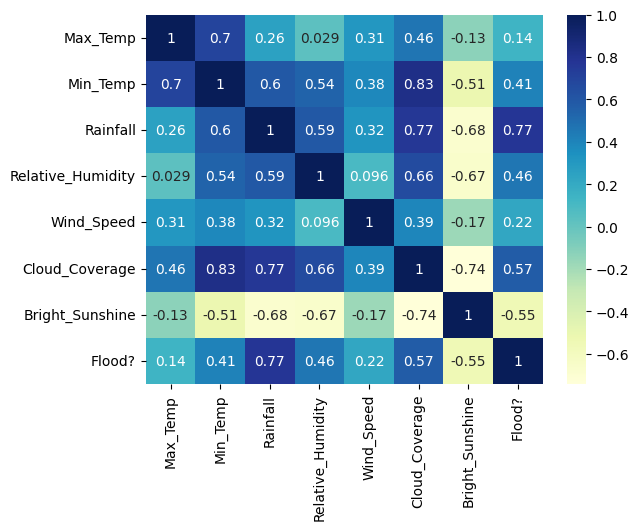

In [8]:
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

array([[<Axes: title={'center': 'Max_Temp'}>,
        <Axes: title={'center': 'Min_Temp'}>,
        <Axes: title={'center': 'Rainfall'}>],
       [<Axes: title={'center': 'Relative_Humidity'}>,
        <Axes: title={'center': 'Wind_Speed'}>,
        <Axes: title={'center': 'Cloud_Coverage'}>],
       [<Axes: title={'center': 'Bright_Sunshine'}>,
        <Axes: title={'center': 'Flood?'}>, <Axes: >]], dtype=object)

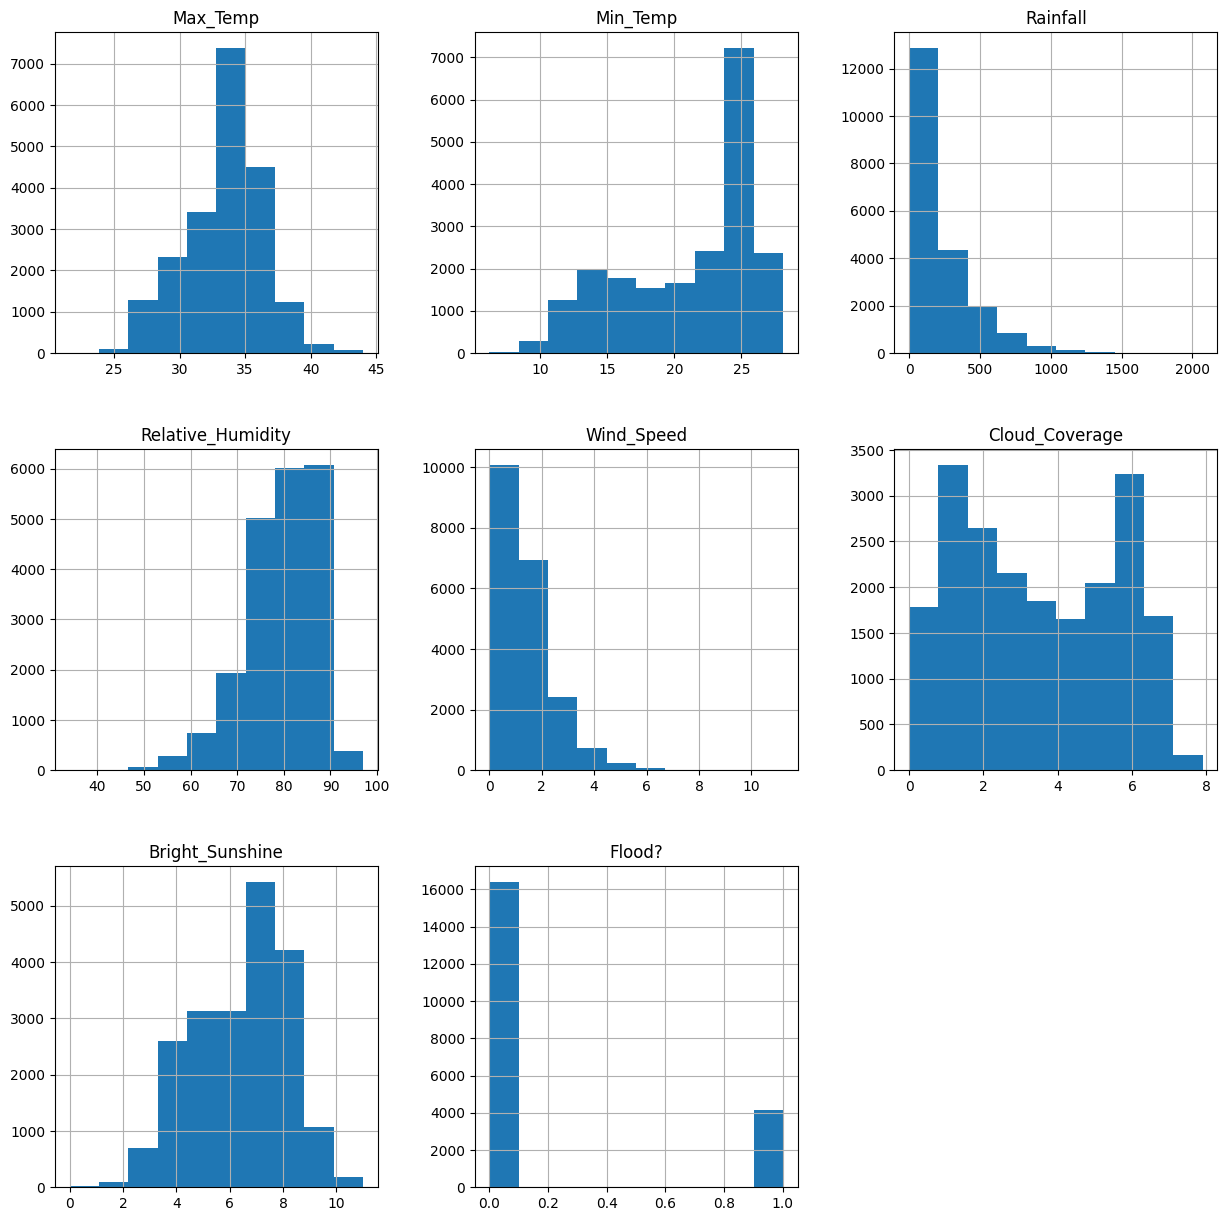

In [9]:
df.hist(figsize=(15,15))

In [10]:
def apply_log(dataframe):
    dataframe["Rainfall"] = np.log(dataframe["Rainfall"] + 1)
    dataframe["Wind_Speed"] = np.log(dataframe["Wind_Speed"] + 1)
apply_log(df)

array([[<Axes: title={'center': 'Max_Temp'}>,
        <Axes: title={'center': 'Min_Temp'}>,
        <Axes: title={'center': 'Rainfall'}>],
       [<Axes: title={'center': 'Relative_Humidity'}>,
        <Axes: title={'center': 'Wind_Speed'}>,
        <Axes: title={'center': 'Cloud_Coverage'}>],
       [<Axes: title={'center': 'Bright_Sunshine'}>,
        <Axes: title={'center': 'Flood?'}>, <Axes: >]], dtype=object)

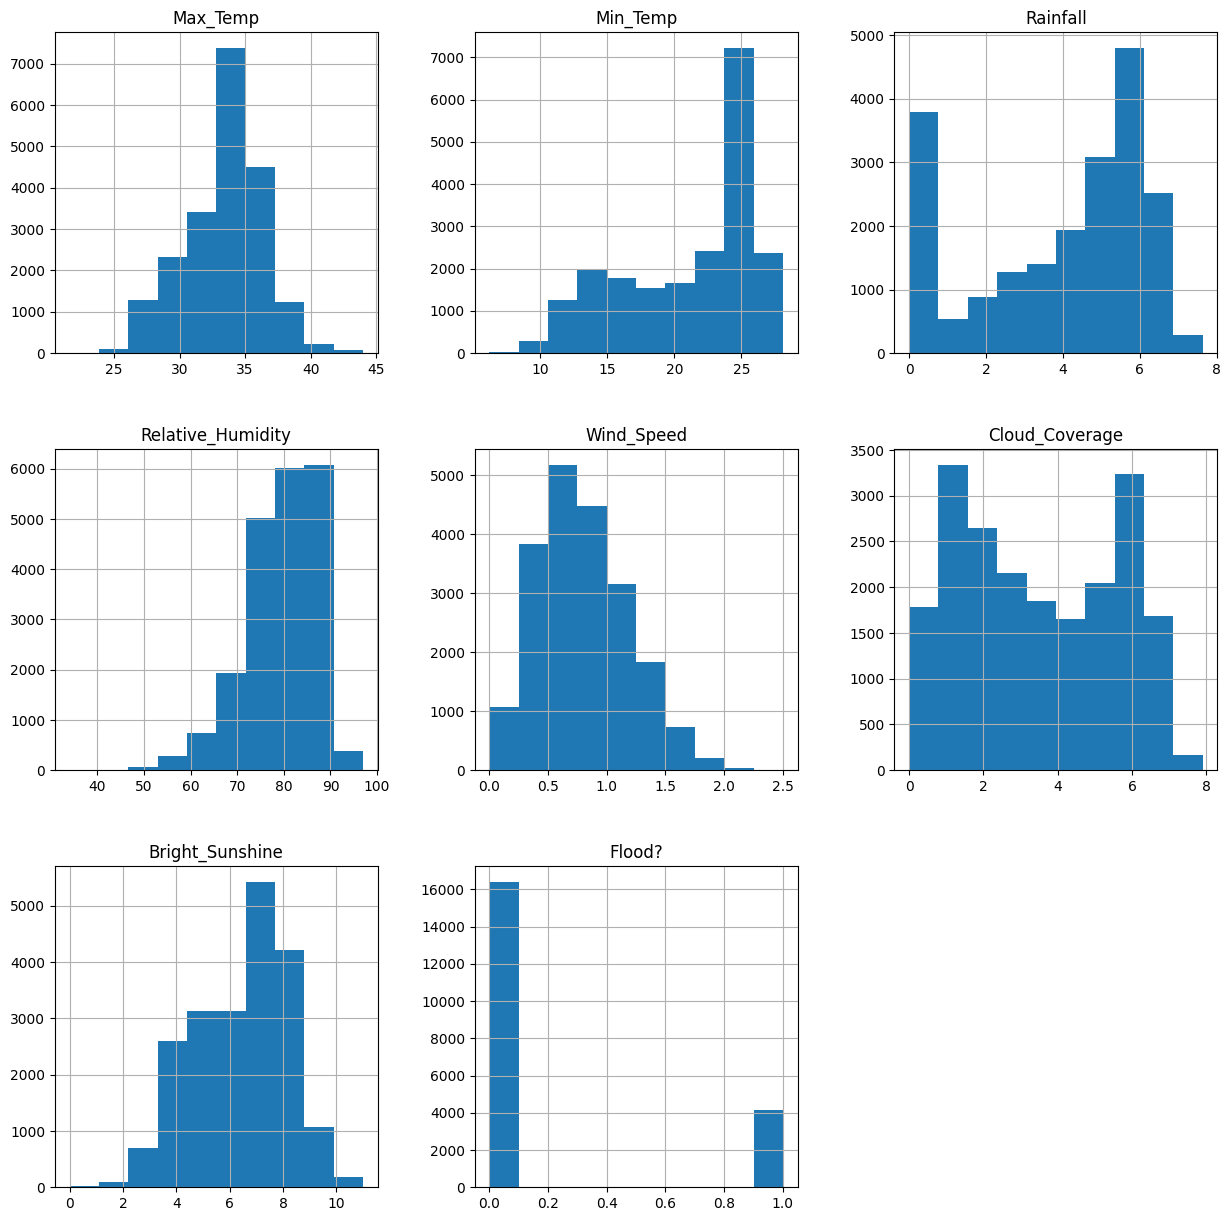

In [11]:
df.hist(figsize=(15,15))

In [12]:
X = df.drop(['Flood?'], axis=1)
y = df["Flood?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [15]:
from sklearn.linear_model import LogisticRegression
model_logis = LogisticRegression()
model_logis.fit(X_train_scaled, y_train_resampled)

y_predict = model_logis.predict(X_test_scaled)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      3245
         1.0       0.71      0.93      0.80       864

    accuracy                           0.90      4109
   macro avg       0.84      0.91      0.87      4109
weighted avg       0.92      0.90      0.91      4109



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
model_rdfr = RandomForestClassifier()

param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(model_rdfr, param_dist, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

print(random_search.best_estimator_)
print(random_search.best_score_)



RandomForestClassifier(max_depth=20)
0.9600518271870422


In [17]:

best_model_rdfr = random_search.best_estimator_
y_predict = best_model_rdfr.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3245
         1.0       0.83      0.89      0.86       864

    accuracy                           0.94      4109
   macro avg       0.90      0.92      0.91      4109
weighted avg       0.94      0.94      0.94      4109



In [18]:
y_prob = best_model_rdfr.predict_proba(X_test)[:, 1]
y_prob

array([0.        , 0.        , 0.03      , ..., 0.        , 0.        ,
       0.99852941])

In [19]:
import joblib
joblib.dump(best_model_rdfr, "model/best_model_rdfr.pkl")


['model/best_model_rdfr.pkl']